In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class Node:
    def __init__(self, attribute=None, threshold=None, label=None, branches=None):
        self.attribute = attribute
        self.threshold = threshold
        self.label = label
        self.branches = branches or {}

def entropy(data, label_index):
    labels = [row[label_index] for row in data]
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def information_gain(data, attribute, label_index):
    total_entropy = entropy(data, label_index)
    weighted_entropy = 0
    
    if isinstance(data[0][attribute], (int, float)):
        values = [float(row[attribute]) for row in data if row[attribute] != 'unknown']
        threshold = np.median(values)
        left_subset = [row for row in data if row[attribute] != 'unknown' and float(row[attribute]) <= threshold]
        right_subset = [row for row in data if row[attribute] != 'unknown' and float(row[attribute]) > threshold]
        
        if left_subset:
            weighted_entropy += len(left_subset) / len(data) * entropy(left_subset, label_index)
        if right_subset:
            weighted_entropy += len(right_subset) / len(data) * entropy(right_subset, label_index)
    else:
        for value in set(row[attribute] for row in data if row[attribute] != 'unknown'):
            subset = [row for row in data if row[attribute] == value]
            weighted_entropy += len(subset) / len(data) * entropy(subset, label_index)
    
    return total_entropy - weighted_entropy

def choose_best_attribute(data, attributes, label_index):
    best_gain = -float('inf')
    best_attribute = None
    best_threshold = None
    
    for attribute in attributes:
        gain = information_gain(data, attribute, label_index)
        if gain > best_gain:
            best_gain = gain
            best_attribute = attribute
            if isinstance(data[0][attribute], (int, float)):
                values = [float(row[attribute]) for row in data if row[attribute] != 'unknown']
                best_threshold = np.median(values)
    
    return best_attribute, best_threshold

def random_forest_tree(data, all_attributes, label_index, max_depth, feature_subset_size):
    labels = [row[label_index] for row in data]
    
    if not labels:
        return Node(label=None)
    
    if len(set(labels)) == 1:
        return Node(label=labels[0])
    
    if len(all_attributes) == 0 or (max_depth is not None and max_depth <= 0):
        return Node(label=max(set(labels), key=labels.count))
    
    # Randomly select a subset of features
    attributes = np.random.choice(all_attributes, min(feature_subset_size, len(all_attributes)), replace=False)
    
    best_attribute, threshold = choose_best_attribute(data, attributes, label_index)
    node = Node(attribute=best_attribute, threshold=threshold)
    
    if threshold is not None:
        left_subset = [row for row in data if row[best_attribute] != 'unknown' and float(row[best_attribute]) <= threshold]
        right_subset = [row for row in data if row[best_attribute] != 'unknown' and float(row[best_attribute]) > threshold]
        if left_subset:
            node.branches[f"<={threshold}"] = random_forest_tree(left_subset, all_attributes, label_index, max_depth-1 if max_depth is not None else None, feature_subset_size)
        if right_subset:
            node.branches[f">{threshold}"] = random_forest_tree(right_subset, all_attributes, label_index, max_depth-1 if max_depth is not None else None, feature_subset_size)
    else:
        for value in set(row[best_attribute] for row in data if row[best_attribute] != 'unknown'):
            subset = [row for row in data if row[best_attribute] == value]
            if subset:
                node.branches[value] = random_forest_tree(subset, all_attributes, label_index, max_depth-1 if max_depth is not None else None, feature_subset_size)
    
    if not node.branches:
        return Node(label=max(set(labels), key=labels.count))
    
    return node

def predict(node, instance):
    if node.label is not None:
        return node.label
    if node.attribute >= len(instance):
        return None
    value = instance[node.attribute]
    if node.threshold is not None:
        if value == 'unknown':
            return None
        if float(value) <= node.threshold:
            branch = f"<={node.threshold}"
        else:
            branch = f">{node.threshold}"
    else:
        branch = value
    if branch not in node.branches:
        return None
    return predict(node.branches[branch], instance)

def bootstrap_sample(data):
    n_samples = len(data)
    return [data[np.random.randint(n_samples)] for _ in range(n_samples)]

def random_forest(data, n_trees, max_depth, feature_subset_size):
    label_index = len(data[0]) - 1
    all_attributes = list(range(len(data[0]) - 1))
    
    trees = []
    for _ in range(n_trees):
        sample = bootstrap_sample(data)
        tree = random_forest_tree(sample, all_attributes, label_index, max_depth, feature_subset_size)
        trees.append(tree)
    
    return trees

def ensemble_predict(trees, instance):
    predictions = [predict(tree, instance) for tree in trees]
    predictions = [p for p in predictions if p is not None]
    return max(set(predictions), key=predictions.count) if predictions else None

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', dtype=str)
    return data.tolist()


Processing 1 trees...
Processing 5 trees...
Processing 10 trees...
Processing 20 trees...
Processing 50 trees...
Processing 100 trees...
Processing 200 trees...
Processing 500 trees...


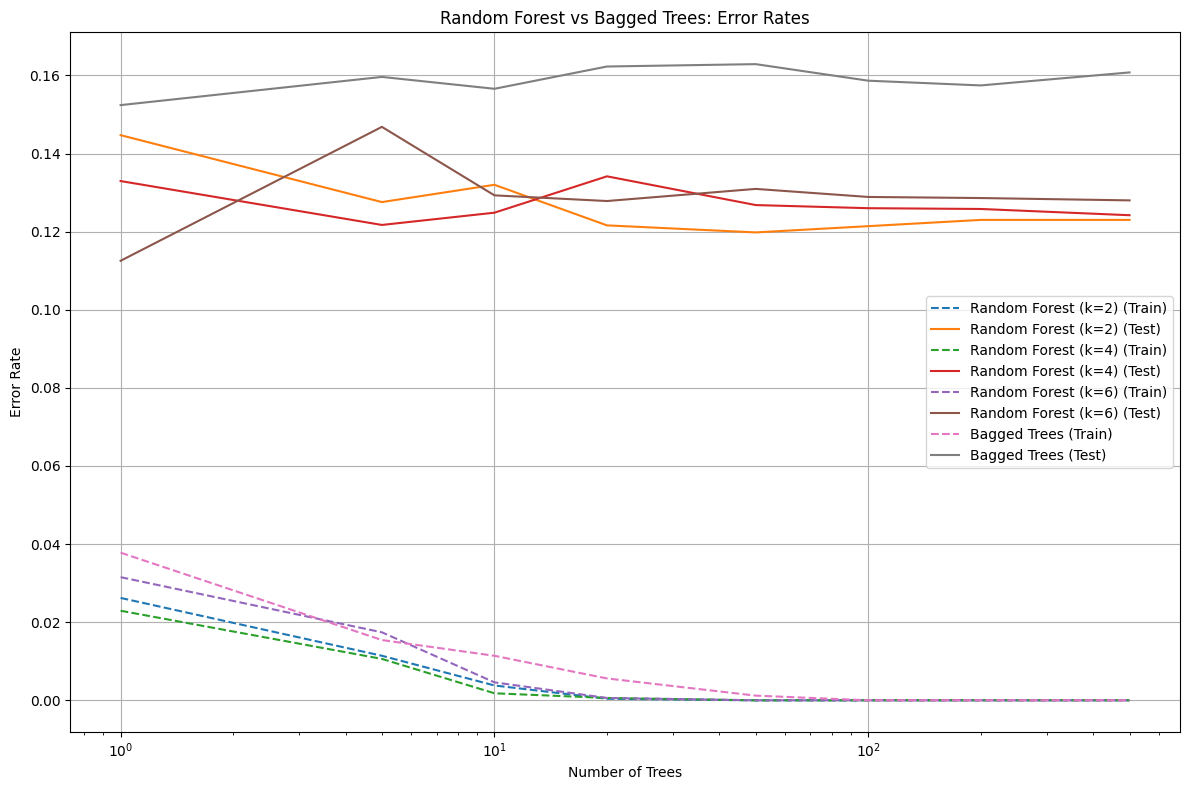


Final Results:
Random Forest (k=2):
  Train Error: 0.0000
  Test Error: 0.1230
Random Forest (k=4):
  Train Error: 0.0000
  Test Error: 0.1242
Random Forest (k=6):
  Train Error: 0.0000
  Test Error: 0.1280
Bagged Trees:
  Train Error: 0.0000
  Test Error: 0.1608


In [2]:

# Load and preprocess data
train_data = load_data('train_bank.csv')
test_data = load_data('test_bank.csv')

# Replace unknown values
for dataset in [train_data, test_data]:
    for attr in range(len(dataset[0]) - 1):
        known_values = [row[attr] for row in dataset if row[attr] != 'unknown']
        if known_values:
            majority = max(set(known_values), key=known_values.count)
            for row in dataset:
                if row[attr] == 'unknown':
                    row[attr] = majority

# Run experiment
n_trees_list = [1, 5, 10, 20, 50, 100, 200, 500]
feature_subset_sizes = [2, 4, 6]
max_depth = None

results = {f'Random Forest (k={k})': {'train': [], 'test': []} for k in feature_subset_sizes}
results['Bagged Trees'] = {'train': [], 'test': []}

for n_trees in n_trees_list:
    print(f"Processing {n_trees} trees...")
    
    # Random Forest
    for k in feature_subset_sizes:
        rf_trees = random_forest(train_data, n_trees, max_depth, k)
        
        rf_train_preds = [ensemble_predict(rf_trees, instance) for instance in train_data]
        rf_test_preds = [ensemble_predict(rf_trees, instance) for instance in test_data]
        
        rf_train_error = np.mean([pred != instance[-1] for pred, instance in zip(rf_train_preds, train_data) if pred is not None])
        rf_test_error = np.mean([pred != instance[-1] for pred, instance in zip(rf_test_preds, test_data) if pred is not None])
        
        results[f'Random Forest (k={k})']['train'].append(rf_train_error)
        results[f'Random Forest (k={k})']['test'].append(rf_test_error)
    
    # Bagged Trees (all features)
    bagged_trees = random_forest(train_data, n_trees, max_depth, len(train_data[0]) - 1)
    
    bagged_train_preds = [ensemble_predict(bagged_trees, instance) for instance in train_data]
    bagged_test_preds = [ensemble_predict(bagged_trees, instance) for instance in test_data]
    
    bagged_train_error = np.mean([pred != instance[-1] for pred, instance in zip(bagged_train_preds, train_data) if pred is not None])
    bagged_test_error = np.mean([pred != instance[-1] for pred, instance in zip(bagged_test_preds, test_data) if pred is not None])
    
    results['Bagged Trees']['train'].append(bagged_train_error)
    results['Bagged Trees']['test'].append(bagged_test_error)

# Plot results
plt.figure(figsize=(12, 8))

for method, errors in results.items():
    plt.plot(n_trees_list, errors['train'], label=f'{method} (Train)', linestyle='--')
    plt.plot(n_trees_list, errors['test'], label=f'{method} (Test)', linestyle='-')

plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('Error Rate')
plt.title('Random Forest vs Bagged Trees: Error Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Results:")
for method, errors in results.items():
    print(f"{method}:")
    print(f"  Train Error: {errors['train'][-1]:.4f}")
    print(f"  Test Error: {errors['test'][-1]:.4f}")